<a href="https://colab.research.google.com/github/brentwong-kiel1997/colab/blob/main/developing_an_Environmental_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#developing an Environmental Score with CII and EXII for ships


## Disclaimer:
* The author of this notebook is [Brent](https://www.linkedin.com/in/mingqianwangbrent987614198/).

* It was originally used for interview purpose with [Oceanis Tech GmbH](https://oceanis.io/).

* For anyone wishes to use any part of it, please be kind enough to cite the source.



# 1.CII : Guidelines from IMO


[MEPC.352(78): 2022 Guidelines on Operational Carbon Intensity Indicators and the Calculation Methods (CII Guidelines, G1)](https://https://wwwcdn.imo.org/localresources/en/KnowledgeCentre/IndexofIMOResolutions/MEPCDocuments/MEPC.352%2878%29.pdf)

[MEPC.353(78): 2022 Guidelines on the Reference Lines for Use with Operational Carbon Intensity Indicators (CII Reference Lines Guidelines, G2)](https://wwwcdn.imo.org/localresources/en/KnowledgeCentre/IndexofIMOResolutions/MEPCDocuments/MEPC.353%2878%29.pdf)

[MEPC.354(78): 2022 Guidelines on the Operational Carbon Intensity Rating of Ships (CII Rating Guidelines, G4)](https://wwwcdn.imo.org/localresources/en/KnowledgeCentre/IndexofIMOResolutions/MEPCDocuments/MEPC.354%2878%29.pdf)


## 1.1 percentiles of dd vectors : key take-away from the guidelines.



[MEPC.354(78)](https://wwwcdn.imo.org/localresources/en/KnowledgeCentre/IndexofIMOResolutions/MEPCDocuments/MEPC.354%2878%29.pdf) contains the most important information for building the grading system.

These Guidelines provide the methods to assign operational energy efficiency performance ratings to ships.


### 1.1.1 dd vectors

dd vectors measure how far the ship's performance, **in terms of CII** , deviates away from the median(required CII). **Negative directions** mean better performance, **positive directions** mean **worse performance**.


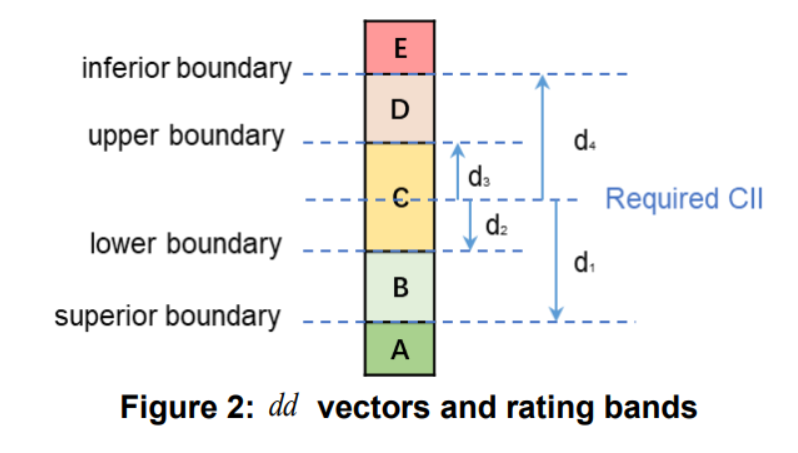

### 1.1.2 percentiles of dd vectors

According to the guidelines, the classifications on CII is based on quantile regression lines.

The percentile lines provide information we can use to infer probabilities. For example, any ship falls on the p=0.15 line, which separates the A and B classes, is only beated by 15% of the ships in the same type in terms of CII.



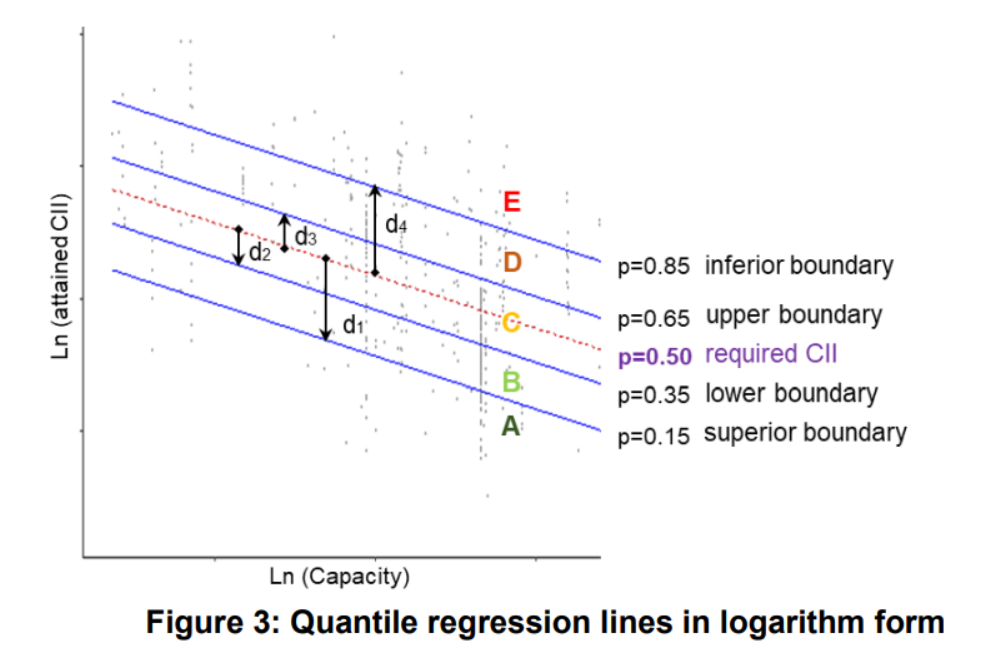

## 1.2 Estimate the CDF of dd vectors(after exponential transformation)



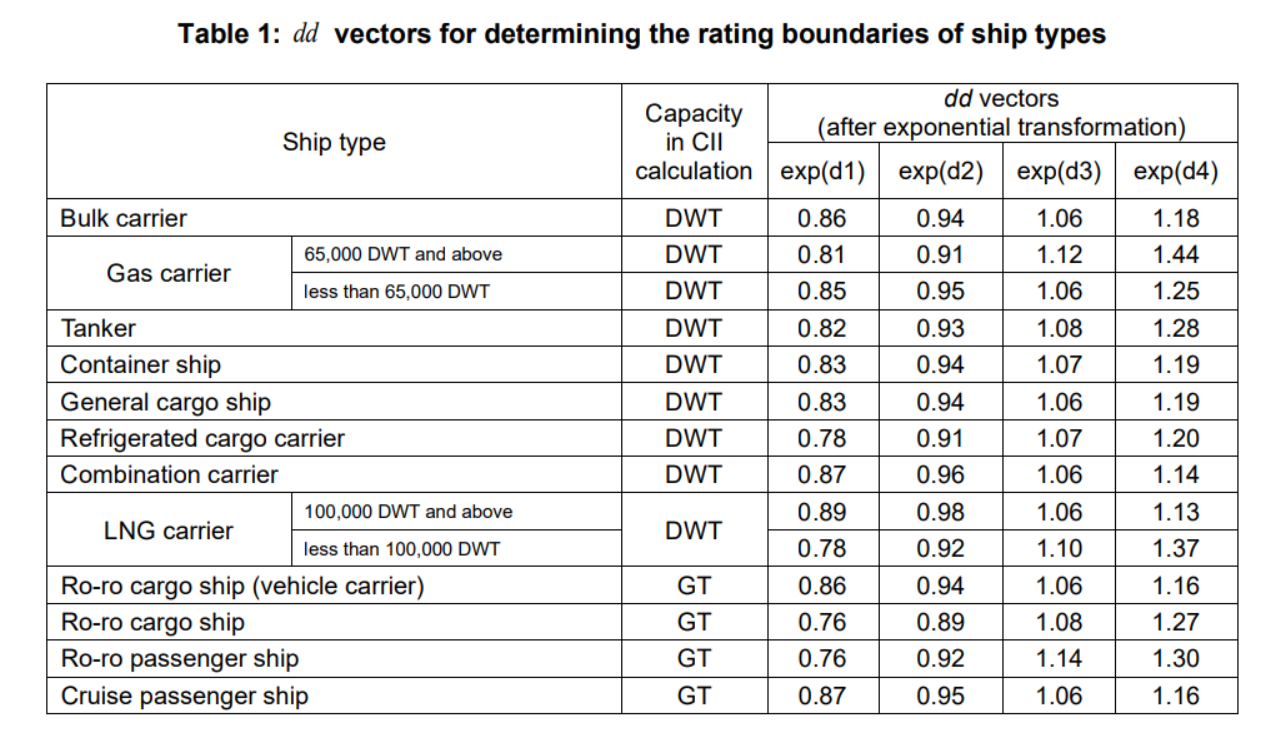

### 1.2.1 calculation of dd vectors(after exponential transformation)

Let's assume we have a ship i and its dd vector is $ d_i $,

$$ \frac{acutal CII}{required CII} = exp(d_i) $$

### 1.2.2 the dd vector for required CII

By defination, the required CII is the median value. And there is no distance between required CII and required CII. The ships sit right on the required CII dd vector line should be beated by 50% of the ships in the same types in terms of CII.

$$ \frac{reuqired CII}{required CII} = exp(0) = 1 $$

### 1.2.3 defination of the CDF of dd vectors

Assume a ship's bb vector is a variable X.

$ P(X<x) $ is the probability of the ship beated by another ship in the same type in terms of CII if the ship has **an observed dd vector of x.**

So the CDF $ F(x) $ is defined as followed,

$$ F(x) = P(X<x) $$

### 1.2.4 data used to find $ \hat{F}(x) $ : using the tanker type as example.

Define $ \hat{F}(x) $ as the estimation of $ F(x) $ .

The following table is the data we can use for tanker type. Apart from the 4 Quantile regression lines, we can also include the required CII line as the median by defination.


| dd vector        | exp(d1)  | exp(d2)   | exp(0)    | exp(d3)   | exp(d4)   |
|------------------|------|------|------|------|------|
|X-Value of dd vector | 0.82 | 0.93 | 1.00 | 1.06 | 1.25 |
| $ F(x)$         | 0.15 | 0.35 | 0.50 | 0.65 | 0.85 |


Let's verify this, based on **2022 guidlines** and CII information from the picture(since I did not find newer guidelines or DWT information), the value of dd vector of the example container is

$$ \frac{actual CII}{required CII} = \frac{8.3}{7.1} \approx 1.169 $$

1.169 lies between exp(d3) and exp(d4), giving us a CII rating of D.



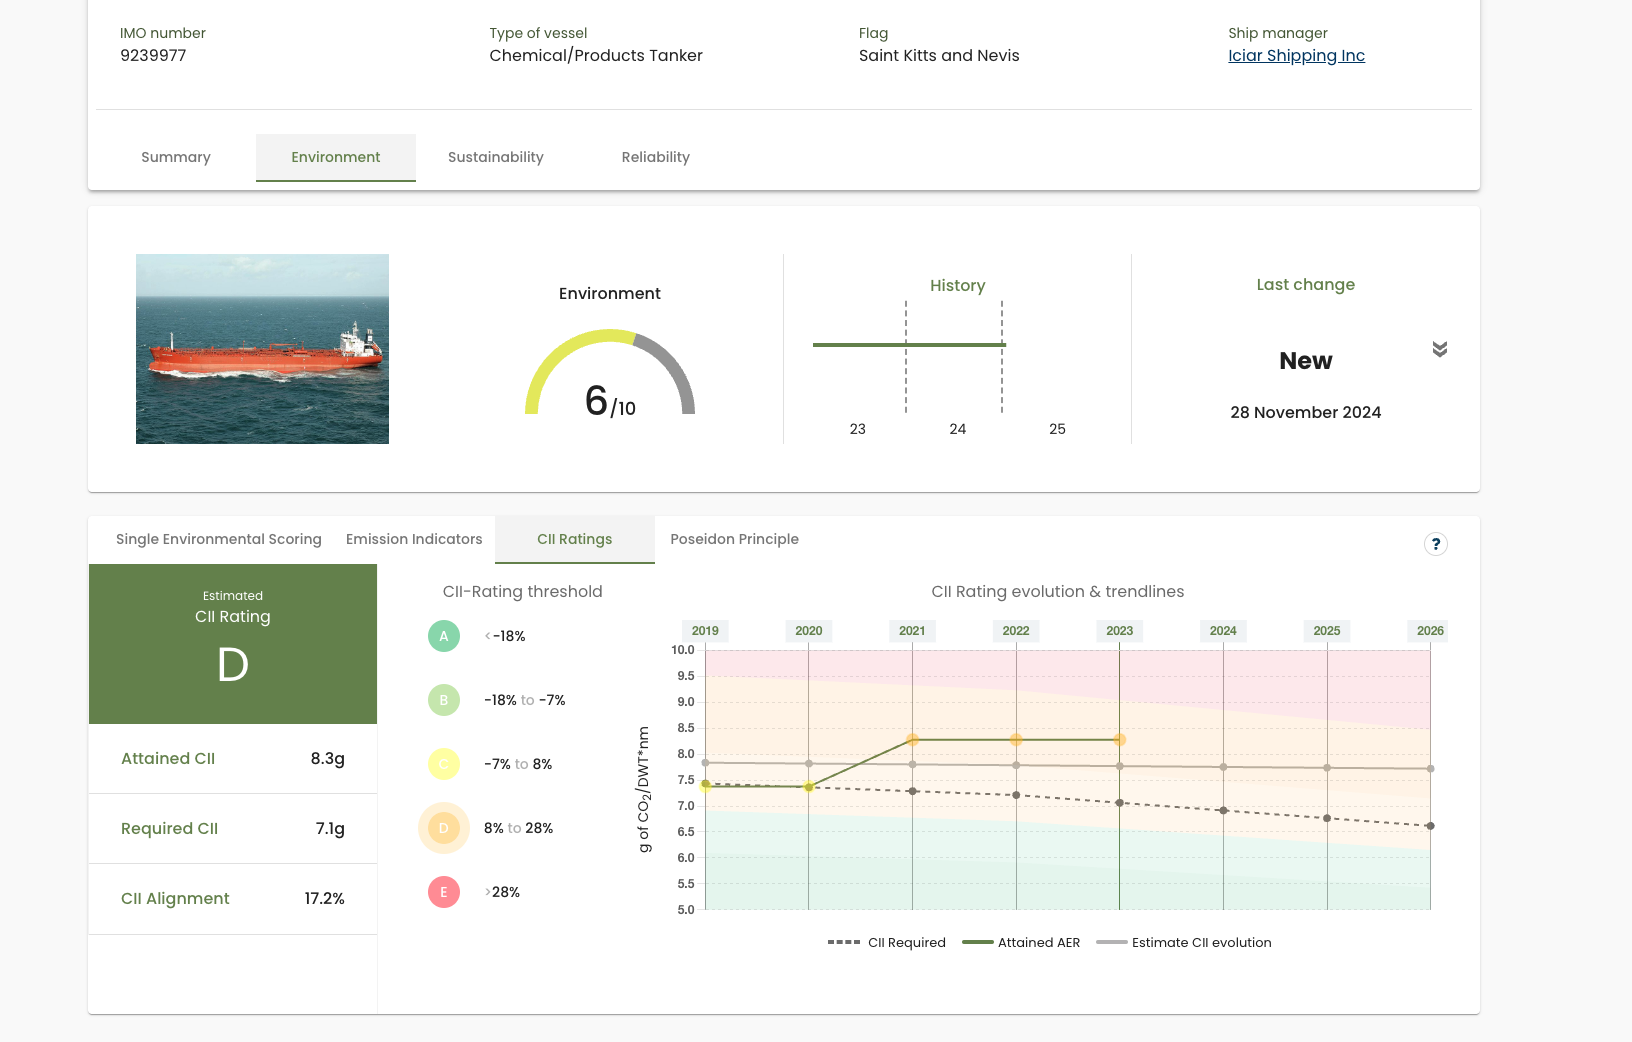

### 1.2.5 the requirements for $ \hat{F}(x) $

1.   $ 0<\hat{F}(x)<1 \quad \forall x $.  The values of CDF needs to land between 0 and 1.
2.   $ \hat{F}(x)\leq\hat{F}(x+\epsilon) \quad \forall \epsilon>0 $. The CDF needs to have a non-negative deriviative(which is the PDF).
3. $ \hat{F}(x)$ needs to pass through all existing points




### 1.2.6 Build the $ \hat{F}(x) $ with piece-wise linear splines

Piece-wise linear spline is just a fancy way to say that we're gonna connect all the dots(knots) with their nearby dots(knots) via straight lines. For each end, we just extend the nearby spline.

Advantages:
1. It meets all the requirements we need for an estimated CDF.
2. We don't have a percise understanding of the shape of the true CDF, so linear splines keep it simple and easy.

Notes for each end:

Since it is a CDF, for any value lager than 1, we set it to 1 and for any value smaller than 0 we set it to 0. We could use non-linear spline at each end to aviod crossing out of the interval of [0, 1]. But it unnecessarily complicates things, no needs for non-linear unless it shows necessities.






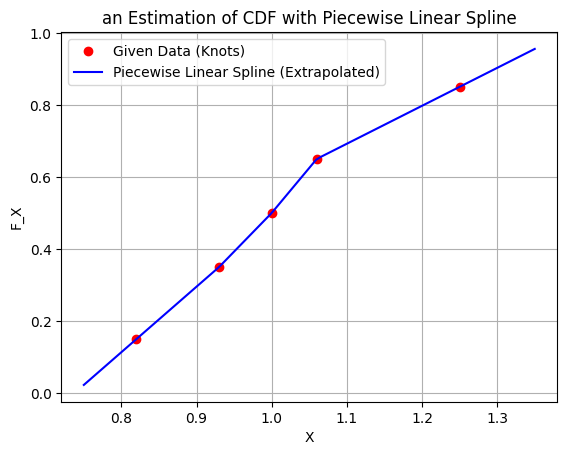

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Given data
X = np.array([0.82, 0.93, 1.00, 1.06, 1.25])
F_X = np.array([0.15, 0.35, 0.50, 0.65, 0.85])

# Create a piecewise linear interpolator with the original data
linear_spline = interp1d(X, F_X, kind='linear', fill_value='extrapolate')

# Evaluate the spline at new points for smooth plotting
X_eval = np.linspace(0.75, 1.35, 100)  # Extend beyond the original range
F_X_eval = linear_spline(X_eval)

# Plot the results
plt.plot(X, F_X, 'o', label='Given Data (Knots)', color='red')
plt.plot(X_eval, F_X_eval, '-', label='Piecewise Linear Spline (Extrapolated)', color='blue')
plt.legend()
plt.xlabel('X')
plt.ylabel('F_X')
plt.title('an Estimation of CDF with Piecewise Linear Spline')
plt.grid(True)
plt.show()

### 1.2.7 estimate the tanker's percentile with dd vector and estimation of CDF with spline

In [ ]:
p_container = linear_spline(8.3/7.1)
print('The CII dd vector percentile of the tanker in the picture:')
print(str(np.round(p_container*100,2))+ '%')

The CII dd vector percentile of the tanker in the picture:
76.48%


The percentile of the example container is 0.7647 showed above. The percentile boundary for CII grading of D is between 0.65 and 0.85, which still gives us the correct grading. Please note that even though it is a simple estimation, it is the best estimation with no database and no further input(I assume the company does not have enough CII data from large enough and diverse enough ships to make such estimation). Most importly, it works as an CDF and is good enough to compare different ships in the same type.

# 2.EEXI : Guidelines from IMO

[MEPC.350(78): Guidelines on the Method of Calculation of the Attained Energy Efficiency Existing Ship Index (EEXI)](https://wwwcdn.imo.org/localresources/en/KnowledgeCentre/IndexofIMOResolutions/MEPCDocuments/MEPC.350(78).pdf)

[MEPC.351(78): Guidelines on Survey and Certification of the Attained Energy Efficiency Existing Ship Index (EEXI)](https://wwwcdn.imo.org/localresources/en/KnowledgeCentre/IndexofIMOResolutions/MEPCDocuments/MEPC.351(78).pdf)

[MEPC.1/Circ.901: Guidance on the Implementation of the Energy Efficiency Existing Ship Index (EEXI)](https://wwwcdn.imo.org/localresources/en/OurWork/Environment/Documents/Air%20pollution/MEPC.1-Circ.901.pdf)

## 2.1 The lack of detailed research and grading system on EEXI compared to CCI

Compared to CII, EEXI does not have a comprehensive data and grading system. Which means, we can not draw an estimated CDF for EEXI.

### 2.1.2 Construc dd vector for EEXI

We can not construct CDF from EEXI, but we can still calculate dd vector for EEXI due to similar design.

$$ dd_{EEXI} =\frac{actual EEXI}{required EEXI} $$

The lower the value is, the more efficient the ship is. If $ dd_{EEXI} < 1$ means it meets the EEXI requirements, else if $ dd_{EEXI} \geq 1$ means it fails to meet the requirements.

# 3.building the scoring system


## 3.1 The core : cost conscious

Since the scoring system is built based on CII and EEXI(related to the regulation requirements), the system should reflect how well a ship meets those regulations. When we put the cost at core, the scoring should indicate the cost level coming with operating a ship under the regulation requirements both at present and in the future.

### 3.1.1 CII : Consequences of Non-Compliance

Failure to meet CII regulations has operational, financial, and reputational implications:

## 1. Operational Restrictions
- Ships with a **D rating for 3 consecutive years** or **E in one year** must implement a **corrective action plan** within their SEEMP to improve efficiency.
- Persistent underperformance may result in **operational limitations** or even **bans from ports or trade routes** by flag states or regional authorities.

## 2. Increased Scrutiny
- Charterers and clients are increasingly favoring efficient ships with better ratings (**A or B**).
- A poor CII rating may lead to **reduced competitiveness** in securing contracts.

## 3. Financial Penalties
- Some ports and regions (e.g., the EU) are considering implementing **carbon taxes or surcharges** based on emissions, further increasing costs for non-compliant ships.
- **Retrofitting and operational changes** to improve efficiency can also be costly.

## 4. Reputation and Market Impact
- A **low CII rating** can damage the ship owner’s reputation in the market, especially as customers and investors demand **greener operations**.

## 5. Legal Consequences
- Non-compliance with IMO regulations may lead to ships being **flagged or detained by port states**, affecting their ability to operate internationally.


### 3.1.2 EEXI : Consequences of Non-Compliance

Failure to meet EEXI regulations has significant operational, financial, and reputational implications:

## 1. Operational Limitations
- Ships that fail to meet EEXI standards may face **restricted operations** or **bans** from certain ports and trade routes.
- Flag states or regional authorities may impose **speed limits** or require additional retrofits to ensure compliance.

## 2. Financial Impacts
- Non-compliance may result in **high retrofitting costs** to upgrade engines, install energy-saving devices, or adopt alternative fuels.
- Non-compliant ships may incur **higher operational costs** due to inefficient fuel use.

## 3. Reduced Market Competitiveness
- Charterers, clients, and shippers are prioritizing energy-efficient ships, making non-compliant vessels less attractive for contracts.
- Ships with poor EEXI compliance may struggle to secure competitive freight rates.

## 4. Reputational Damage
- Failing to comply with EEXI standards can tarnish the ship owner's reputation, especially as the industry and stakeholders demand **greener operations**.

## 5. Legal Consequences
- Ships that fail to comply with EEXI regulations may be **detained by port state control** or flagged as non-compliant, impacting their ability to operate in international waters.


## 3.2 building the scoring system

### 3.2.1 using the percentile of CII dd vector as baseline

Intuitively, using 10% as interval we can evenly separate ships' CII(dd vectors) into 10 different score. (0%-10% as score 1 and so on, 1 as the best and 10 as the worst).


Of course, it is also possible to separate the percentile of CII(dd vectors) with uneven intervals.

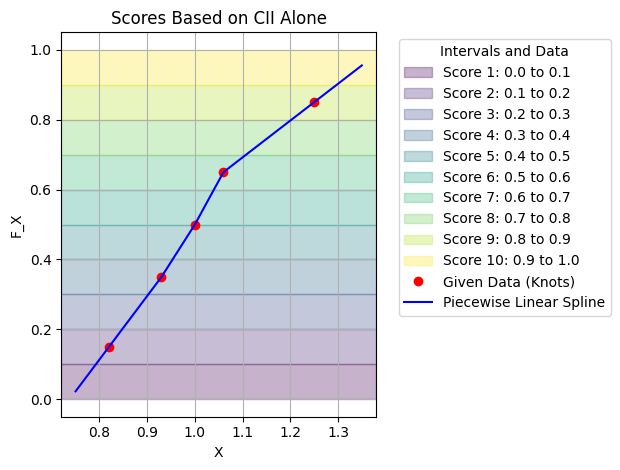

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Given data
X = np.array([0.82, 0.93, 1.00, 1.06, 1.25])
F_X = np.array([0.15, 0.35, 0.50, 0.65, 0.85])

# Create a piecewise linear interpolator with the original data
linear_spline = interp1d(X, F_X, kind='linear', fill_value='extrapolate')

# Evaluate the spline at new points for smooth plotting
X_eval = np.linspace(0.75, 1.35, 100)  # Extend beyond the original range
F_X_eval = linear_spline(X_eval)

# Plot the background with different shades for each interval
y_intervals = np.arange(0, 1.1, 0.1)  # 0, 0.1, ..., 1
colors = plt.cm.viridis(np.linspace(0, 1, len(y_intervals) - 1))  # Different shades

# Add new legends for intervals
for i in range(len(y_intervals) - 1):
    plt.axhspan(y_intervals[i], y_intervals[i + 1], color=colors[i], alpha=0.3,
                label=f'Score {i + 1}: {y_intervals[i]:.1f} to {y_intervals[i + 1]:.1f}')

# Plot the results
plt.plot(X, F_X, 'o', color='red', label='Given Data (Knots)')
plt.plot(X_eval, F_X_eval, '-', color='blue', label='Piecewise Linear Spline')

# Customize legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Intervals and Data')

# Add labels, title, and grid
plt.xlabel('X')
plt.ylabel('F_X')
plt.title('Scores Based on CII Alone')
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing with legend
plt.show()


base on the data in the piture we can score the tanker.

In [ ]:
score = np.ceil(10*p_container)
print('The score we can give the tanker based on CII alone:')
print(int(score))

The score we can give the tanker based on CII alone:
8


#### conclusion on CII scoring alone

With the CII alone, it does seem unfair to give this tanker(in the picture) an environmental score of 6. It is significantly worse than majority of the ships in the tanker type. While operating this ship, ship owner will bear a larger cost under CII regulations compared to others.

### 3.2.2 EEXI factor

As showed in section 2.1.2

$$ dd_{EEXI} =\frac{actual EEXI}{required EEXI} $$



## construct the EEXI factor(one example)

$$ EEXI factor = (dd_{EEXI})^\alpha $$



*   $\alpha $ is the cost indicator for failing to meet the EEXI standards ($\alpha \geq 0 $).

## Mechanism of the EEXI factor

1. When $ dd_{EEXI} $ is less than one, the EEXI factor will be less than one. It means the ship meets the EEXI requirements. The lower the $ dd_{EEXI} $ and
EXXI factor are, the better the ship is. Vice versa.

2. $\alpha $ works as an amplifier or compressor for the $ dd_{EEXI} $. If $\alpha=0$ then all EEXI factors are 1, it means the cost of failing to meet the EEXI standards is 0, it would not have an effect on the cost while operating an ship with EEXI as consideration. If $\alpha>1$, it amplifies the  $ dd_{EEXI} $ . The larger $\alpha$ is, the larger the cost of failing to meet EEXI is.


Any other construction of EEXI can also be considered as long as they fulfill the above mechanism




### 3.2.3 combine the EEXI factor and the percentile of CII dd vector(one example, not the only method)

With above discussion, we can easily pull out a model-free scoring method based on a ship's EEXI and CII without needing additional data or input.

$$ rawScore = (dd_{EEXI})^\alpha (\hat{F}(x))^\beta $$



*   $ \beta >0 $.  $ \beta $ is the amplifier or compressor for $\hat{F}(x)$ with cost as the consideration. When $ 1>\beta >0 $, it acts as an amplifier(it might be a bit hard to put your head around this, just remember that $1>\hat{F}(x)>0$ as a CDF).


## The choice of $\alpha$ and $\beta$

In practice, the choices of $\alpha$ and $\beta$ need to be more carefully calculated based on the purpose of the scoring system and experiences in the industry.
The choice here is just for demonstration.


*   $\beta = 1$. In 3.2.1, we have already used CII as the baseline. It makes sense here to use 1.
*   $\alpha \gg 1$. $\alpha $ needs to have a value that is significantly larger than 1, since it will cost the ship owner a lot when the ship failes to meet the EEXI standards
* EEXI factor can move the baseline score up and down the chart based on its value. When EEXI factor is less than 1, it moves base score down, indicating that the cost of operating this ship with EEXI in consideration is less.




#### The example in the picture

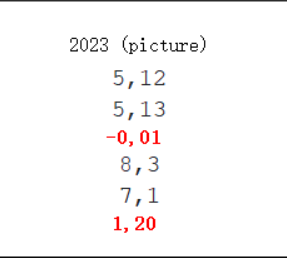

In [ ]:
alpha = 150
EEXI_factor = 5.12/5.13
rawScore = np.power(EEXI_factor, alpha)*p_container

In [ ]:
rawScore

0.5707025491934462

In [ ]:
print('updated score with EEXI: ')
print(int(np.ceil(rawScore*10)))

updated score with EEXI: 
6


As we see in 3.2.1, this tanker ship has a **score of 8 based on CII alone**, which is fair. This tanker performances worse than 76% of the ships in the same type.

However, when a ship fails to meet the EEXI standards, the measures ship owners need to take can be costly, including,


1. **Retrofitting and Equipment Installation**: Installing energy-efficient technologies (e.g., air lubrication systems, energy-saving devices, or advanced hull coatings) can be expensive. Retrofitting a vessel may cost several hundred thousand dollars to millions, depending on the vessel size and technology used.

2. **Engine Power Limitation**: If a ship's engine power needs adjustment to comply with EEXI, this could require substantial costs for equipment upgrades or replacements. Modifications might include changes to the engine, exhaust systems, or power management systems.

3. **Operational Changes**: Operational adjustments, such as reducing ship speed or optimizing routes to save fuel, could affect cargo capacity or delivery times, potentially impacting profitability.

4. **Alternative Fuels**: Switching to lower-carbon fuels, such as LNG or biofuels, can incur high costs due to fuel sourcing, storage, and usage. Additionally, infrastructure investment may be required, especially for fleets not already set up for alternative fuels.

5. **Ongoing Maintenance and Monitoring**: To stay EEXI-compliant, ships must continuously monitor and maintain systems, as well as report performance. This involves additional operational costs, including monitoring systems and energy management platforms.

Since this tanker still meets the EEXI requirements, it is also reasonably that EEXI factor moves the score down to 6 in order to reflect the avoided cost (with large enough $\alpha$).

# 4.final thoughts

Here are some final thoughts in bullets points:

1. **CII as the baseline** CII has more detailed information, the percentile method. When we don't have enough data, CII provides us a reasonable baseline in a model-free method.

2. **Cost as core: purpose of the score** The purpose of the score is to provide the customers with a comprehensive rating on the ship's environmental efficiency. This environmental efficiency is translated into quantifiable metrics and costs under IMO regulations. When we put cost at the core of the score, we also have a clear understanding how we should distribute the weight between CII and EEXI.

3. **Ways to combine CII and EEXI** As already mentioned in 3.2.3, the example is just one way to combine CII and EEXI. We could also use EEXI as a discrete element, for example when EEXI factor is less than 1, move the score down 2 class, vice versa. The important part is to insure the mechanism reflects the cost level.